# _Solanum sp._ Chromosome 7

#### __Step 1:__ Data `.vcf` to `.h5` processing

In [4]:
# import ipyrad.analysis as ipa
import pandas as pd
import sklearn
import numpy as np
import allel

In [5]:
# %%bash

# # compress the VCF file if not already done (creates .vcf.gz)
# bgzip data/ch07.vcf

# # remove multi-allelic SNPs and INDELs and PIPE to next command
# bcftools view --types snps -Ou -o data/ch07.cleaned.vcf data/ch07.vcf.gz

# # recompress the final file (create .vcf.gz)
# bgzip data/ch07.cleaned.vcf

In [7]:
# allel.vcf_to_hdf5('data/ch07.cleaned.vcf.gz', 'analysis-vcf2hdf5/ch07.cleaned.h5')

In [8]:
# # load the VCF as an datafram
# dfchunks = pd.read_csv(
#     "data/ch01.cleaned.vcf.gz",
#     sep="\t",
#     skiprows=1000,
#     chunksize=1000,
# )

# # show first few rows of first dataframe chunk
# next(dfchunks).head()

In [9]:
# # init a conversion tool
# converter = ipa.vcf_to_hdf5(
#     name="S.lycospericum_chr7",
#     data="data/ch07.cleaned.vcf.gz",
#     ld_block_size=20000,
# )

# # run the converter
# converter.run()

In [10]:
# pca = ipa.pca(
#     data="./analysis-vcf2hdf5/S.lycospericum_chr7.snps.hdf5",
#     mincov=1.0,
# )

#### __Step 2:__ Extracting and transforming `.h5` data

In [11]:
# Import modules.
import allel
import h5py
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns

In [12]:
# Load the hdf5 data.
chr7_data = h5py.File('./analysis-vcf2hdf5/ch07.cleaned.h5', mode='r')
# Extract the genotypes.
chr7_gt = allel.GenotypeArray(chr7_data['calldata/GT'][:])
# Extract the variable positions array.
chr7_pos = allel.SortedIndex(chr7_data['variants/POS'][:])
# Extract the samples array.
chr7_samps = np.array([samp.decode() for samp in chr7_data['samples'][:]])

In [13]:
chr7_length = 68045021

# Adjust the total chromosome length for 50kb windows.
chr7_adj_len = (chr7_length // 50_000) * 50_000
# Intialize a dicctionary with the start and stop position for each window.
wind_dicc = {}
# Intialize a midpoint list.
mid_points = []
# Intialize a window index counter.
index = 0
# For all 50kb window...
for window_start in range(1, chr7_length, 50_000):
    # If this is the last window...
    if window_start == chr7_length:
        # Break the for loop since there are too few sites in the last window.
        break
    # Else...
    else:
        # Fill the dictionary with the position indices.
        wind_dicc[index] = np.where(((window_start <= chr7_pos) & (chr7_pos < (window_start + 50_000))))[0]
        # Append the midpoint list.
        mid_points.append(window_start + 25_000)
        # Move the window index forward.
        index += 1
# # Determine the optix gene indices.
# optix_idx = np.where(((1058778 <= chr7_pos) & (chr7_pos <= 1159581)))[0]
# # Intialize the windows the optix gene is in.
# optix_wind = np.array([21, 22, 23])
# # Intialize the x-axis ticks.
# x_ticks = np.arange(0, 350, 30)
# # Intialize the x-axis tick labels.
# x_labels = (np.arange(0, chr78_adj_len, 1_500_000) / 1_000_000).astype(str)

In [14]:
# Extract the species id from samples labels.
species_id = [sample.split('_')[0] for sample in chr7_samps]
# Create a metadata dataframe.
chr7_meta_df = pd.DataFrame({'samples': chr7_samps, 'species': species_id})
# Extract the unique sample ids.
chr7_species = chr7_meta_df['species'].unique()
# Subset the focal species.
focal_chr7_species = chr7_species[:-1]
# Intialize a dictionary to store sample ids.
chr7_idx_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary.
    chr7_idx_dicc[spc] = chr7_meta_df[chr7_meta_df['species'] == spc].index.values

In [15]:
# Convert the genotypes to an alternative allele count matrix.
chr7_aac = chr7_gt.to_n_alt(fill=np.nan, dtype=np.float64)
# Intialize an allele count matrix dictionary.
chr7_aac_dicc = {}
# intialize a alternative allele frequency dictionary.
chr7_freq_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary with the subsetted alternative allele count matrix.
    chr7_aac_dicc[spc] = chr7_aac[:, chr7_idx_dicc[spc]]
    # Determine the number of chromosomes with allele calls.
    called_chroms = np.count_nonzero(~np.isnan(chr7_aac_dicc[spc]), axis=1) * 2
    # Determine the allele counts of the derived/alternative allele.
    per_site_aac = np.nansum(chr7_aac_dicc[spc], axis=1)
    # Fill the frequency dictionary.
    chr7_freq_dicc[spc] = per_site_aac / called_chroms

/var/folders/3y/6tny1g211js_j838x23dfbv40000gq/T/ipykernel_65658/2339683515.py:16: RuntimeWarning: invalid value encountered in divide
  chr7_freq_dicc[spc] = per_site_aac / called_chroms


#### __Step 3:__ PCA on all samples

In [16]:
# Get Solanum lycopersicum var. cerasiforme (SLC) and var. lycopersicum (SLL) sample ids.

slc_metadata = pd.read_csv('data/metadata/SLC_metadata.csv')
sll_metadata = pd.read_csv('data/metadata/SLL_metadata.csv')

slc_samps = np.array(slc_metadata.Label.unique())
sll_samps = np.array(sll_metadata.Label.unique())

# Get Solanum pennellii (SP) sample ids.
sp_metadata = pd.read_csv('data/metadata/SP_metadata.csv')
sp_samps = np.array(sp_metadata.Label.unique())


In [17]:
slc_aac = np.concatenate([chr7_aac_dicc[samp] for samp in slc_samps], axis=1)
sll_aac = np.concatenate([chr7_aac_dicc[samp] for samp in sll_samps], axis=1)

sp_aac = np.concatenate([chr7_aac_dicc[samp] for samp in sp_samps], axis=1)

all_aac = np.concatenate([slc_aac, sll_aac, sp_aac], axis=1)
all_aac = np.nan_to_num(all_aac, nan=0)
# all_aac = np.nan_to_num(slc_aac, nan=0)

In [18]:
print(slc_aac.shape) # needs 106?.. update metadata
print(sll_aac.shape)
print(sp_aac.shape)
print(all_aac.shape)

(663742, 103)
(663742, 20)
(663742, 26)
(663742, 149)


In [19]:
# Calculate the column mean vector.
mu_vec = np.mean(all_aac, axis=0)
# Calculate the column allele frequency vector.
p_vec = mu_vec / 2
# Calculate the standard deviation vector.
std_vec = np.sqrt(((all_aac.shape[0] * 2) * p_vec * (1 - p_vec)))
# Convert the C matrix to a zero centered M matrix.
M_mat = (all_aac - mu_vec) / std_vec

In [20]:
# Compute the covariance matrix.
X_mat = np.cov(M_mat, rowvar=False)

In [21]:
# Compute the eigen -values and -vectors.
eig_vals, eig_vecs = np.linalg.eig(X_mat)
# Sort the -values and -vectors.

# Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
eig_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[eig_idx]
eig_vecs = eig_vecs[:, eig_idx]

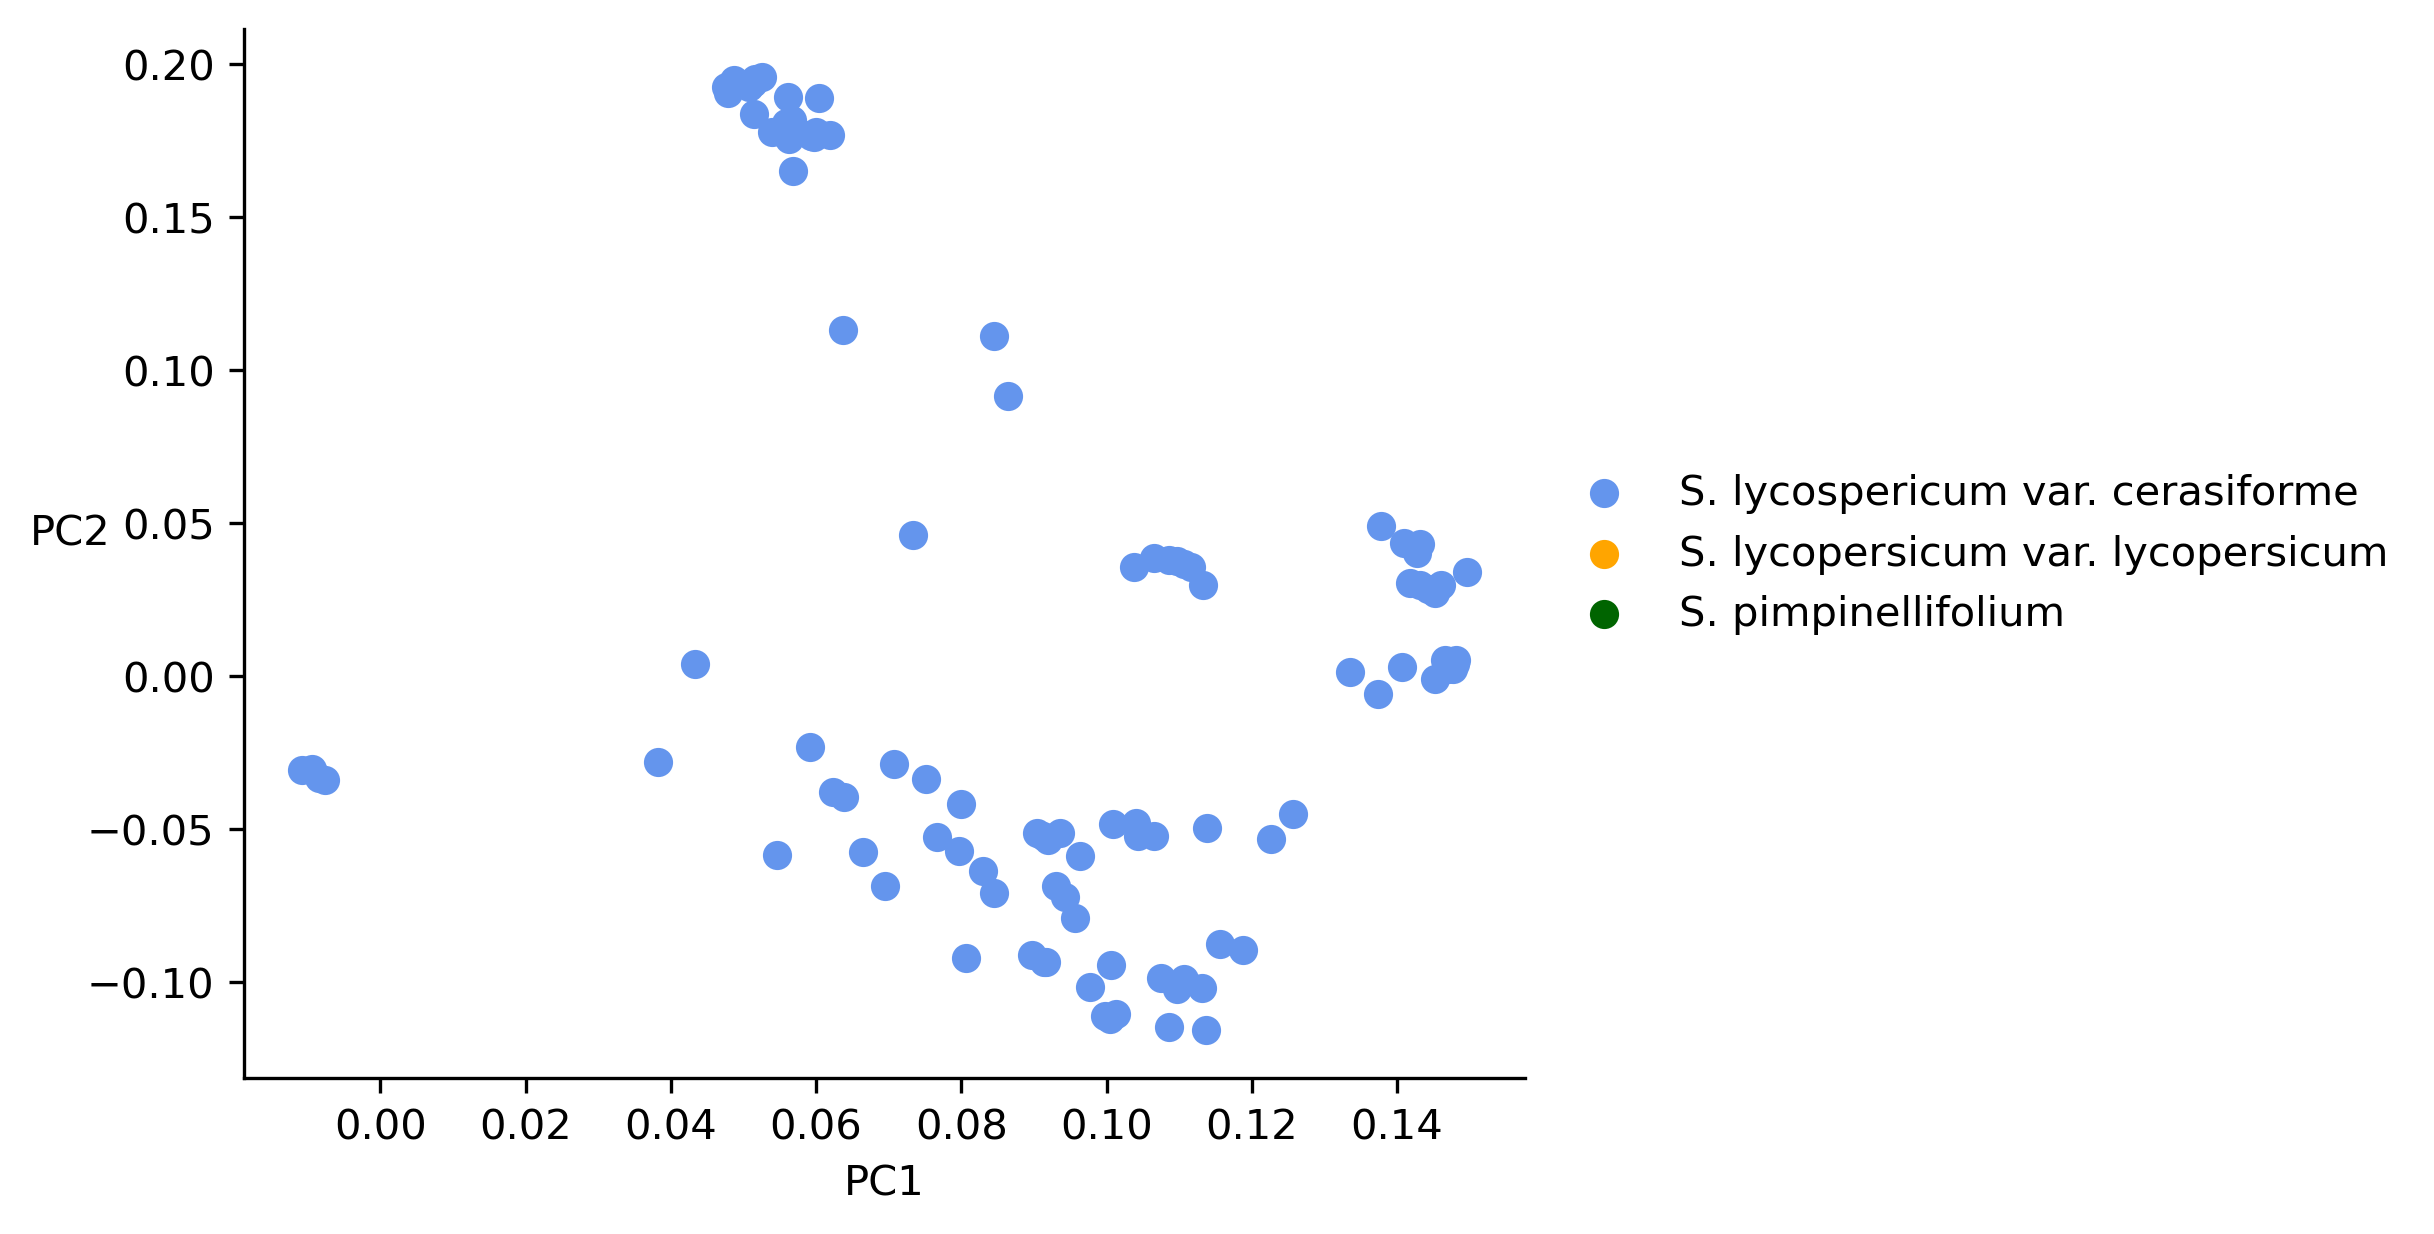

In [42]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot points
ax.scatter(
    eig_vecs[:103, 0], eig_vecs[:103, 1],
    color='cornflowerblue', label='S. lycospericum var. cerasiforme',
)
ax.scatter(
    eig_vecs[103:123, 0], eig_vecs[103:123, 1],
    color='orange', label='S. lycopersicum var. lycopersicum',
)
ax.scatter(
    eig_vecs[123:, 0], eig_vecs[123:, 1],
    color='darkgreen', label='S. pimpinellifolium',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

#### __Step 3.5:__ Geography subset PCA on _S. lyco. var. cerasiforme_

In [23]:
slc_locs = slc_metadata.Origin.unique()
print(slc_locs)

['Ecuador' 'Peru' 'Mexico' 'Costa Rica' 'El Salvador' 'Honduras'
 'Colombia' 'Nicaragua']


In [24]:
slc_meta_dicc = {}
for loc in slc_locs:
    slc_meta_dicc[loc] = slc_aac[:, slc_metadata.Origin == loc]

# slc_meta_dicc = {
#     'ECU' : slc_metadata[:, slc_metadata.Origin == 'Ecuador'],
#     'PER' : slc_metadata[:, slc_metadata.Origin == 'Peru'],
#     'MEX' : slc_metadata[:, slc_metadata.Origin == 'Mexico'],
#     'COS' : slc_metadata[:, slc_metadata.Origin == 'Costa Rica'],
#     'ELS' : slc_metadata[:, slc_metadata.Origin == "El Salvador"],
# }

In [25]:
print([mat.shape for mat in slc_meta_dicc.values()])

[(663742, 40), (663742, 29), (663742, 21), (663742, 5), (663742, 2), (663742, 2), (663742, 3), (663742, 1)]


In [26]:
slc_aac = np.nan_to_num(slc_aac, nan=0)

def calc_pca(aac_mat):
    # Calculate the column mean vector.
    mu_vec = np.mean(aac_mat, axis=0)
    # Calculate the column allele frequency vector.
    p_vec = mu_vec / 2
    # Calculate the standard deviation vector.
    std_vec = np.sqrt(((aac_mat.shape[0] * 2) * p_vec * (1 - p_vec)))
    # Convert the C matrix to a zero centered M matrix.
    M_mat = (aac_mat - mu_vec) / std_vec

    # Compute the covariance matrix.
    X_mat = np.cov(M_mat, rowvar=False)

    # Compute the eigen -values and -vectors.
    eig_vals, eig_vecs = np.linalg.eig(X_mat)
    # Sort the -values and -vectors.

    # Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
    eig_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[eig_idx]
    eig_vecs = eig_vecs[:, eig_idx]

    return eig_vals, eig_vecs

eig_vals, eig_vecs = calc_pca(slc_aac)

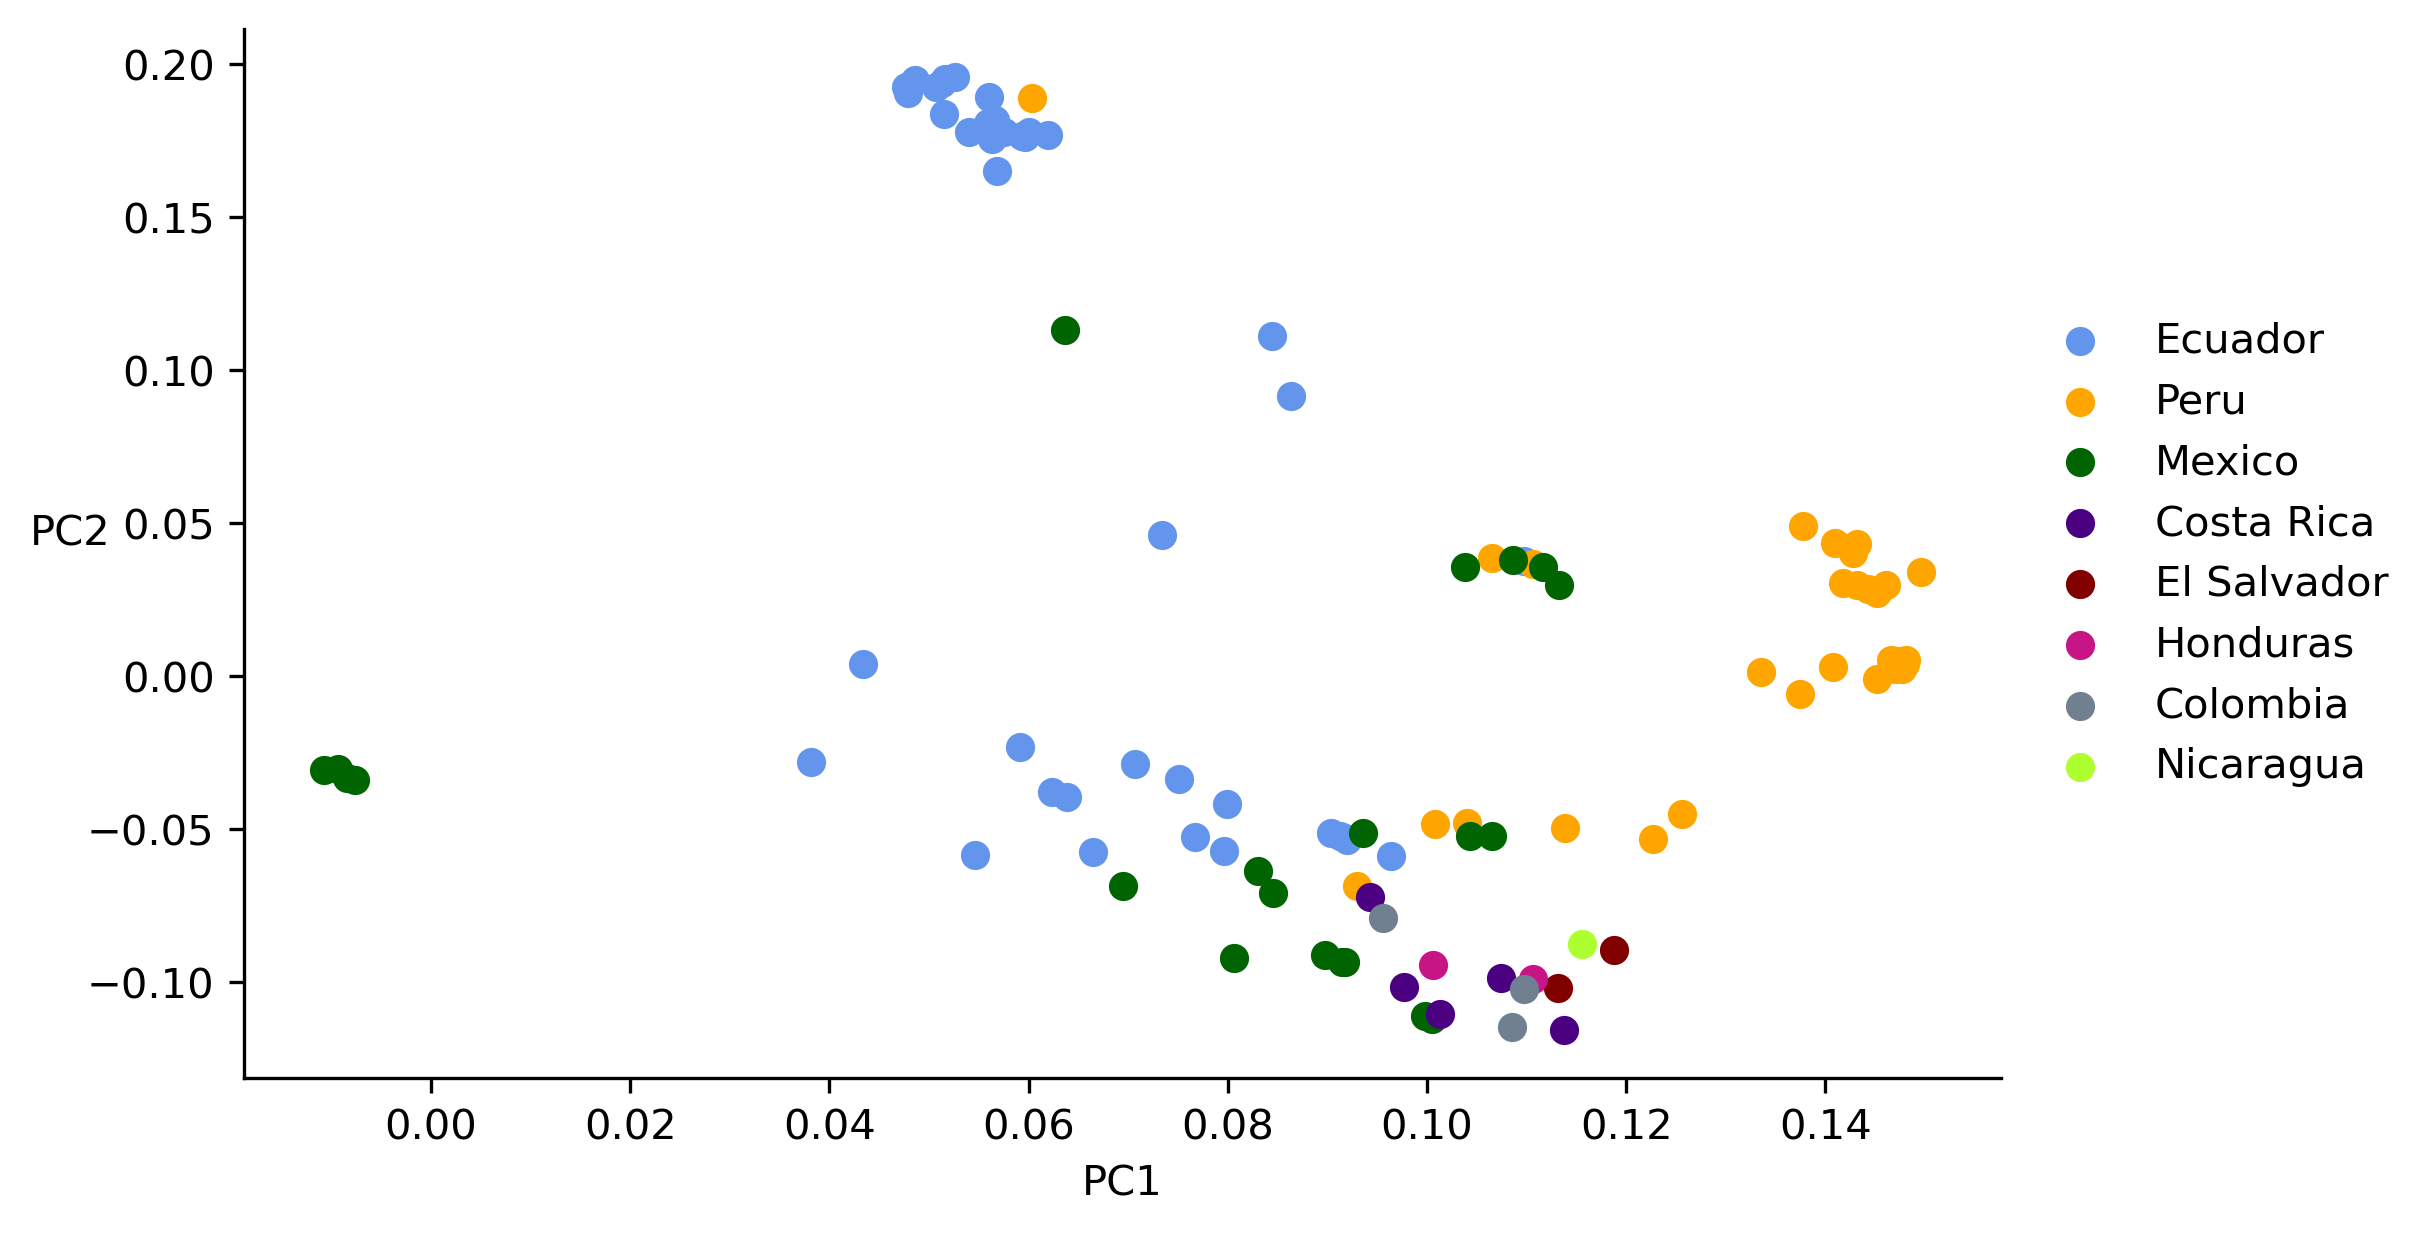

In [27]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot points
ax.scatter(
    eig_vecs[:40, 0], eig_vecs[:40, 1],
    color='cornflowerblue', label='Ecuador',
)
ax.scatter(
    eig_vecs[40:69, 0], eig_vecs[40:69, 1],
    color='orange', label='Peru',
)
ax.scatter(
    eig_vecs[69:90, 0], eig_vecs[69:90, 1],
    color='darkgreen', label='Mexico',
)
ax.scatter(
    eig_vecs[90:95, 0], eig_vecs[90:95, 1],
    color='indigo', label='Costa Rica',
)
ax.scatter(
    eig_vecs[95:97, 0], eig_vecs[95:97, 1],
    color='maroon', label='El Salvador',
)
ax.scatter(
    eig_vecs[97:99, 0], eig_vecs[97:99, 1],
    color='mediumvioletred', label='Honduras',
)
ax.scatter(
    eig_vecs[99:102, 0], eig_vecs[99:102, 1],
    color='slategray', label='Colombia',
)
ax.scatter(
    eig_vecs[102:, 0], eig_vecs[102:, 1],
    color='greenyellow', label='Nicaragua',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

#### __Step 4:__ Nucleotide diversity and pairwise Fst for Peruvian and Ecuadorean _S. lyco. var. cerasiforme_

In [29]:
WINDOW = 150_000
LENGTH = 68_045_021
# Adjust the total chromosome length for 50kb windows.
chr_adj_len = (LENGTH // WINDOW) * WINDOW
# Intialize a dicctionary with the start and stop position for each window.
wind_dicc = {}
# Intialize a midpoint list.
mid_points = []
# Intialize a window index counter.
index = 0
# For all 50kb window...
for window_start in range(1, LENGTH, WINDOW):
    # If this is the last window...
    if window_start >= (chr_adj_len+1):
        # Break the for loop since there are too few sites in the last window.
        break
    # Else...
    else:
        # Fill the dictionary with the position indices.
        wind_dicc[index] = np.where(((window_start <= chr7_pos) & (chr7_pos < (window_start + WINDOW))))[0]
        # Append the midpoint list.
        mid_points.append(window_start + (WINDOW/2))
        # Move the window index forward.
        index += 1
# Determine the optix gene indices.
# optix_idx = np.where(((1058778 <= chr1_pos) & (chr1_pos <= 1159581)))[0]
# # Intialize the windows the optix gene is in.
# optix_wind = np.array([21, 22, 23])
# Intialize the x-axis ticks.
x_ticks = np.arange(0, 600, 30)
# Intialize the x-axis tick labels.
x_labels = (np.arange(0, chr_adj_len, 5_000_000) / 1_000_000).astype(str)

In [30]:
def avg_fst(pop_a_freqs, pop_b_freqs):
    # Calculate the average gene diversity within the populations.
    H_w = ((pop_a_freqs * (1 - pop_a_freqs)) + (pop_b_freqs * (1 - pop_b_freqs)))
    # Calculate the average gene diversity between populations.
    H_b = ((pop_a_freqs * (1 - pop_b_freqs)) + (pop_b_freqs * (1 - pop_a_freqs)))
    # Calculatae the numerator and denominator of Fst.
    fst_num = H_b - H_w
    fst_den = H_b
    # Calculate the per site Fst.
    per_site_fst = fst_num / fst_den
    # Calculate the average Fst for this locus.
    fst = np.sum(fst_num) / np.sum(fst_den)
    return fst

In [31]:
# Define a function to calculate nucleotide diversity per site.
def pixy(genotype_matrix):
    """Returns an of array nucleotide diversity for a genotype
       matrix with missing data.

    genotype_matrix -- numpy matrix with a shape of (sites x chromosomes).
    """
    # Determine the number of called genotypes for each site.
    called_genotypes = np.count_nonzero(~np.isnan(genotype_matrix), axis=1) * 2
    # Create a mask where there are no called genotypes.
    mask = called_genotypes == 0
    # Determine the allele counts of the derived/alternative allele.
    derived_allele_count = np.nansum(genotype_matrix, axis=1)
    # Determine the allele counts of the ancestral/reference allele.
    ancestral_allele_count = called_genotypes - derived_allele_count
    # Determine the number of comparisons per site.
    nC2 = np.array([((n * (n - 1)) / 2) for n in called_genotypes])
    # Calculate the numerator.
    numerator = np.nanmean(
        (derived_allele_count[~mask] * ancestral_allele_count[~mask])
    )
    # Calculate the denominator.
    denominator = np.nanmean(nC2[~mask])
    # Calculate pixy.
    pi_pixy = numerator / denominator
    return pi_pixy

In [32]:
mex_ids = np.array(slc_metadata[slc_metadata.Origin == 'Mexico'].Label)
ecu_ids = np.array(slc_metadata[slc_metadata.Origin == 'Ecuador'].Label)

In [34]:
# Extract the species id from samples labels.
species_id = []

for id in [sample.split('_')[0] for sample in chr7_samps]:
    if id in mex_ids:
        species_id.append('Mexico')
    elif id in ecu_ids:
        species_id.append('Ecuador')
    else:
        species_id.append('Other')

In [35]:
## RERUN THE FREQUENCY CALCULATION CODE WITH NEW IDENTIFIED SPECIMENS ##

# Create a metadata dataframe.
chr7_meta_df = pd.DataFrame({'samples': chr7_samps, 'species': species_id})
# Extract the unique sample ids.
chr7_species = chr7_meta_df['species'].unique()
# Subset the focal species.
focal_chr7_species = chr7_species[:-1]
# Intialize a dictionary to store sample ids.
chr7_idx_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary.
    chr7_idx_dicc[spc] = chr7_meta_df[chr7_meta_df['species'] == spc].index.values

# Convert the genotypes to an alternative allele count matrix.
chr7_aac = chr7_gt.to_n_alt(fill=np.nan, dtype=np.float64)
# Intialize an allele count matrix dictionary.
chr7_aac_dicc = {}
# intialize a alternative allele frequency dictionary.
chr7_freq_dicc = {}
# For every species...
for spc in chr7_species:
    # Fill the dictionary with the subsetted alternative allele count matrix.
    chr7_aac_dicc[spc] = chr7_aac[:, chr7_idx_dicc[spc]]
    # Determine the number of chromosomes with allele calls.
    called_chroms = np.count_nonzero(~np.isnan(chr7_aac_dicc[spc]), axis=1) * 2
    # Determine the allele counts of the derived/alternative allele.
    per_site_aac = np.nansum(chr7_aac_dicc[spc], axis=1)
    # Fill the frequency dictionary.
    chr7_freq_dicc[spc] = per_site_aac / called_chroms

In [36]:
# Renaming chr7 freq dictionary as slc with only mexico and ecuador
slc_freq_dicc = {}

for loc in ['Mexico', 'Ecuador']:
    slc_freq_dicc[loc] = chr7_freq_dicc[loc]

In [37]:
### SKELETON FOR PERFORMING COMPUTATIONS IN WINDOWS ###

# Intialize a dictionary to store the results.
results_dicc = {
    'pi_mex': [], 'pi_ecu': [],
    'fst': []
}

# For every window...
for idx in wind_dicc.keys():
    # Identify the variable sites indices for the current window.
    wind_sites_idx = wind_dicc[idx]
    mex_mat = slc_meta_dicc['Mexico'][wind_sites_idx, :]
    ecu_mat = slc_meta_dicc['Ecuador'][wind_sites_idx, :]
    
    # Get frequencies
    mex_freqs = slc_freq_dicc['Mexico'][wind_sites_idx]
    ecu_freqs = slc_freq_dicc['Ecuador'][wind_sites_idx]

    # Compute pi_{pixy}.
    pi_mex = pixy(mex_mat)
    pi_ecu = pixy(ecu_mat)
    
    
    # Compute Fst.
    fst_mex_ecu = avg_fst(mex_freqs, ecu_freqs)
    
    # Fill the dictionary.
    results_dicc['pi_mex'].append(pi_mex)
    results_dicc['pi_ecu'].append(pi_ecu)
    results_dicc['fst'].append(fst_mex_ecu)

/var/folders/3y/6tny1g211js_j838x23dfbv40000gq/T/ipykernel_65658/3060495289.py:10: RuntimeWarning: invalid value encountered in divide
  per_site_fst = fst_num / fst_den
/var/folders/3y/6tny1g211js_j838x23dfbv40000gq/T/ipykernel_65658/1272530244.py:19: RuntimeWarning: Mean of empty slice
  numerator = np.nanmean(
/var/folders/3y/6tny1g211js_j838x23dfbv40000gq/T/ipykernel_65658/1272530244.py:23: RuntimeWarning: Mean of empty slice
  denominator = np.nanmean(nC2[~mask])
/var/folders/3y/6tny1g211js_j838x23dfbv40000gq/T/ipykernel_65658/3060495289.py:12: RuntimeWarning: invalid value encountered in scalar divide
  fst = np.sum(fst_num) / np.sum(fst_den)


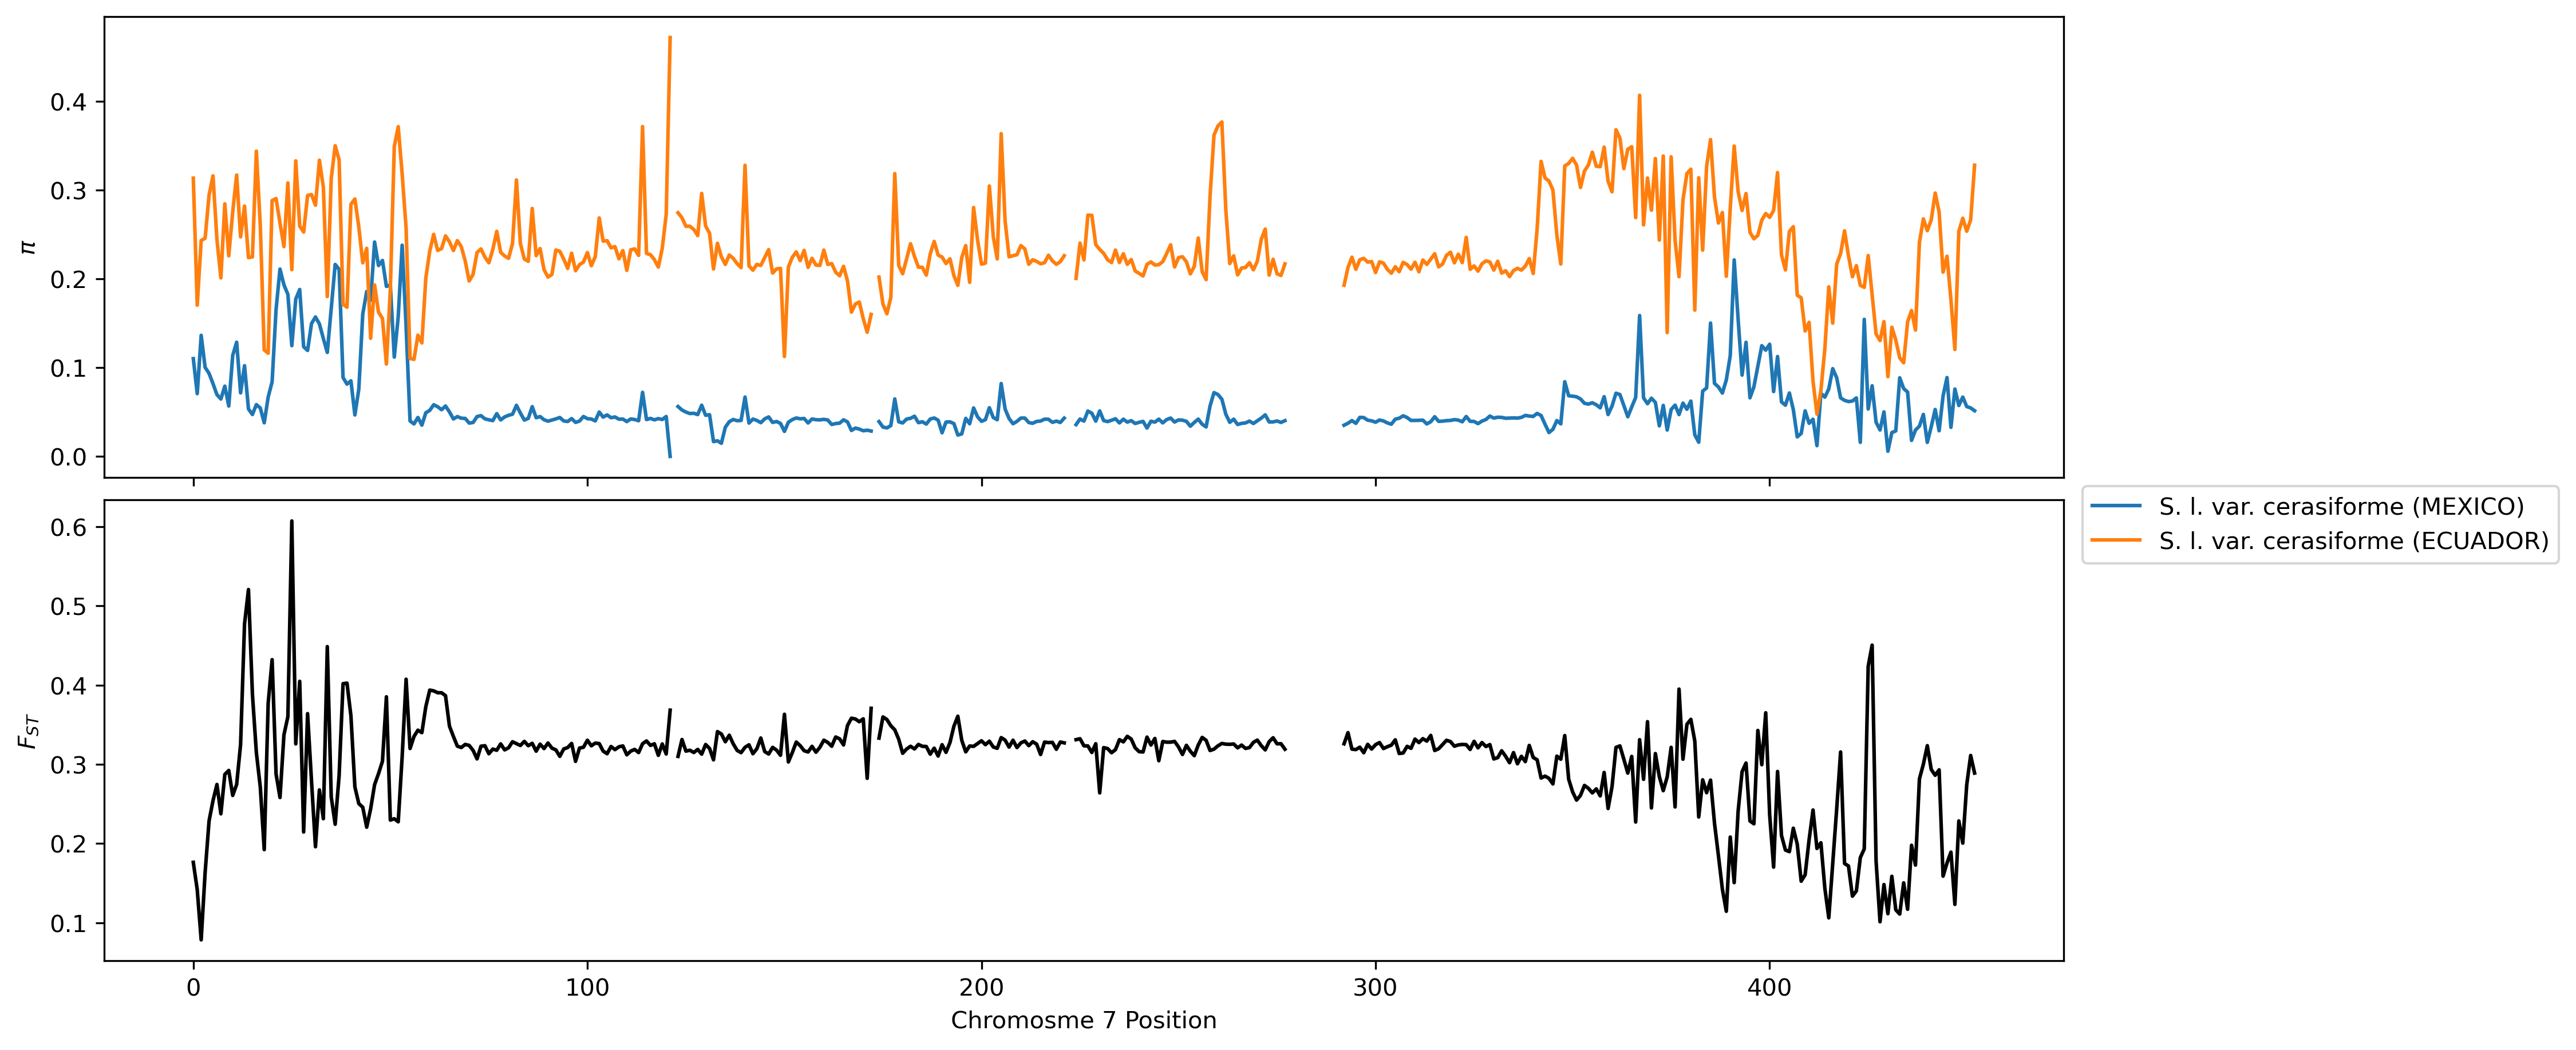

In [41]:
### PLOTTING CODE IF YOU USED MY CODE FROM ABOVE ###

# Intialize the figure and axes.
fig, axes = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True, sharey=False, 
    constrained_layout=True, dpi=300,
)
# Plot nucleotide diversity.
axes[0].plot(
    results_dicc['pi_mex'], color='tab:blue',
    label="S. l. var. cerasiforme (MEXICO)",
)
axes[0].plot(
    results_dicc['pi_ecu'], color='tab:orange',
    label="S. l. var. cerasiforme (ECUADOR)",
)
# Plot fst.
axes[1].plot(results_dicc['fst'], color='black')
# Plot D+.
# axes[2].plot(results_dicc['dplus_mal'], color='tab:blue')
# axes[2].plot(results_dicc['dplus_ama'], color='tab:orange')
# axes[2].text(
#     90, 0.5, '((({0}, {1}), P3), {2})'.format(
#         heli_name_dicc['chi'], heli_name_dicc['flo'], heli_name_dicc['nu_sil'],
#     ),
# )
# Plot the optix gene region.
# axes[0].axvline(
#     21, linewidth=15, color='red',
#     label=r'$optix$', alpha=0.5,
# )
# axes[1].axvline(21, linewidth=15, color='red',alpha=0.5)
# axes[2].axvline(21, linewidth=15, color='red',alpha=0.5)
# Add the legend.
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Set the x-axis.
# axes[2].set_xticks(x_ticks)
# axes[2].set_xticklabels(x_labels)
axes[1].set_xlabel('Chromosme 7 Position')
# Label the y-axes.
axes[0].set_ylabel(r'$\pi$')
axes[1].set_ylabel(r'$F_{ST}$')
# axes[2].set_ylabel(r'$D+$')
# Show the plot.
plt.show()